# 1/N vs Markowitz vs Continuous Markowtitz

We will now for the first time apply this theory to real data. We will get a family of tradeable assets and pick three different portfolios. One just takes the same amount of each asset, another one applies Modern Portfolio Theory to find the one with the best sharpe and a different one does the same, but rebalancing that portfolio periodically.

The approach will be very simple, taking historical means and covariances as the returns and covariances used by mean-variance model.

In [39]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime
from scipy.optimize import minimize
import plotly.graph_objects as go

In [3]:
tickers = ["QQQ","VEA","VTV","SPY","BND"]
data = yf.download(tickers)
data

[*********************100%%**********************]  5 of 5 completed


Adj Close                                                 \
                  BND         QQQ         SPY        VEA         VTV   
Date                                                                   
1993-01-29        NaN         NaN   25.029371        NaN         NaN   
1993-02-01        NaN         NaN   25.207390        NaN         NaN   
1993-02-02        NaN         NaN   25.260786        NaN         NaN   
1993-02-03        NaN         NaN   25.527822        NaN         NaN   
1993-02-04        NaN         NaN   25.634630        NaN         NaN   
...               ...         ...         ...        ...         ...   
2023-08-17  70.720001  358.579987  436.290009  44.630001  142.059998   
2023-08-18  70.870003  358.130005  436.500000  44.630001  142.399994   
2023-08-21  70.529999  363.899994  439.339996  44.770000  142.169998   
2023-08-22  70.620003  363.380005  438.149994  44.669998  141.320007   
2023-08-23        NaN  368.536194  441.730011  45.070301  141.720093   

                Close                                                 ...  \
                  BND         QQQ         SPY        VEA         VTV  ...   
Date                                                                  ...   
1993-01-29        NaN         NaN   43.937500        NaN         NaN  ...   
1993-02-01        NaN         NaN   44.250000        NaN         NaN  ...   
1993-02-02        NaN         NaN   44.343750        NaN         NaN  ...   
1993-02-03        NaN         NaN   44.812500        NaN         NaN  ...   
1993-02-04        NaN         NaN   45.000000        NaN         NaN  ...   
...               ...         ...         ...        ...         ...  ...   
2023-08-17  70.720001  358.579987  436.290009  44.630001  142.059998  ...   
2023-08-18  70.870003  358.130005  436.500000  44.630001  142.399994  ...   
2023-08-21  70.529999  363.899994  439.339996  44.770000  142.169998  ...   
2023-08-22  70.620003  363.380005  438.149994  44.669998  141.320007  ...   
2023-08-23        NaN  368.536194  441.730011  45.070301  141.720093  ...   

                 Open                                                 \
                  BND         QQQ         SPY        VEA         VTV   
Date                                                                   
1993-01-29        NaN         NaN   43.968750        NaN         NaN   
1993-02-01        NaN         NaN   43.968750        NaN         NaN   
1993-02-02        NaN         NaN   44.218750        NaN         NaN   
1993-02-03        NaN         NaN   44.406250        NaN         NaN   
1993-02-04        NaN         NaN   44.968750        NaN         NaN   
...               ...         ...         ...        ...         ...   
2023-08-17  70.800003  363.959991  441.160004  45.110001  143.020004   
2023-08-18  70.760002  355.260010  433.369995  44.299999  141.429993   
2023-08-21  70.610001  359.619995  437.549988  44.730000  142.419998   
2023-08-22  70.550003  366.549988  441.179993  44.959999  142.339996   
2023-08-23        NaN  364.579987  439.250000  44.889999  141.559998   

               Volume                                               
                  BND         QQQ       SPY         VEA        VTV  
Date                                                                
1993-01-29        NaN         NaN   1003200         NaN        NaN  
1993-02-01        NaN         NaN    480500         NaN        NaN  
1993-02-02        NaN         NaN    201300         NaN        NaN  
1993-02-03        NaN         NaN    529400         NaN        NaN  
1993-02-04        NaN         NaN    531500         NaN        NaN  
...               ...         ...       ...         ...        ...  
2023-08-17  7357800.0  62604300.0  95711300  10996300.0  1820500.0  
2023-08-18  5094100.0  61119500.0  98758400  11576400.0  2434500.0  
2023-08-21  4280100.0  50696500.0  68719000  10914300.0  2194400.0  
2023-08-22  4301900.0  44530200.0  64994200  10252400.0  1712200.0  
2023-08-23        

In [8]:
prices = data["Adj Close"]
prices = prices[prices.isna().sum(axis=1)==0]

In [10]:
log_returns = np.log(prices / prices.shift(1)).dropna()
log_returns

,BND,QQQ,SPY,VEA,VTV
Date,,,,,
2007-07-27,-0.000803,-0.020419,-0.019856,-0.015357,-0.021836
2007-07-30,-0.000938,0.011602,0.015523,0.016609,0.016529
2007-07-31,0.002010,-0.021233,-0.011328,-0.001252,-0.015069
2007-08-01,-0.000484,0.007754,0.004861,0.004167,0.011612
2007-08-02,0.001746,0.009144,0.007959,-0.002915,0.000865
...,...,...,...,...,...
2023-08-16,-0.002821,-0.010645,-0.007365,-0.007981,-0.005592
2023-08-17,-0.000989,-0.010983,-0.007649,-0.006699,-0.004215
2023-08-18,0.002119,-0.001256,0.000481,0.000000,0.002390


In [16]:
TRADING_DAYS = 252
RFR = 0.02

### 1/N

<Axes: xlabel='Date'>

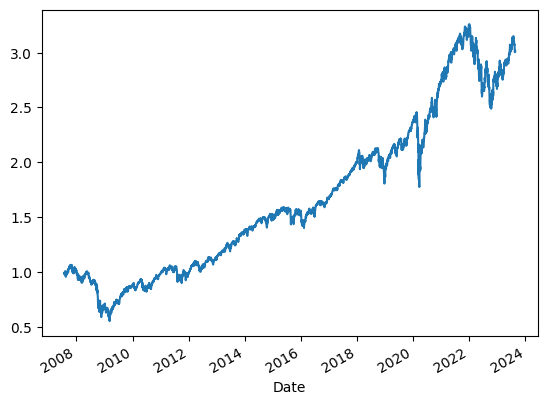

In [17]:
n_assets = log_returns.shape[1]
w = np.ones(n_assets)/n_assets

weighted_returns = log_returns.dot(w)
wealth_evolution = np.exp(weighted_returns.cumsum())
wealth_evolution.plot()

In [24]:
def sharpe(returns, risk_free_rate, trading_days):
    excess_returns = returns - risk_free_rate / (trading_days / pd.to_timedelta(1, unit='D').days)
    sharpe_ratio = np.sqrt(trading_days) * excess_returns.mean() / excess_returns.std()
    return sharpe_ratio
rets = wealth_evolution.pct_change().dropna()
sharpe_ratio = sharpe(rets,RFR, TRADING_DAYS)
print(f"SR: {sharpe_ratio:.4f}")

SR: 0.3843


### Markowitz

Note how for calculating the optimal mean-variance portfolio we need some expected returns and covariances. For any reasonable expectation, we should have some past data, so we must start investing later than with the 1/N portfolio. We will assume our assets remain uninvested for that period of time.

In [35]:
def calculate_mean_variance_portfolio(expected_returns, cov_matrix, risk_free_rate):
    num_assets = len(expected_returns)

    def objective(weights):
        portfolio_return = np.dot(weights, expected_returns)
        portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
        sharpe_ratio = (portfolio_return - risk_free_rate) / np.sqrt(portfolio_variance)
        return -sharpe_ratio  # Minimize the negative Sharpe ratio to maximize the Sharpe ratio

    initial_weights = np.ones(num_assets) / num_assets
    bounds = tuple((0, 1) for _ in range(num_assets))
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})


    result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

    optimal_weights = result.x
    optimal_portfolio_return = np.dot(optimal_weights, expected_returns)
    optimal_portfolio_variance = np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights))
    optimal_sharpe_ratio = (optimal_portfolio_return - risk_free_rate) / np.sqrt(optimal_portfolio_variance)

    return optimal_weights, optimal_sharpe_ratio

In [43]:
start_investing = datetime(year=2012,month=1,day=1)
historic_returns = log_returns[log_returns.index < start_investing]
ann_returns = np.exp(historic_returns.sum()*TRADING_DAYS/len(historic_returns)) - 1
normal_historic_returns = historic_returns.apply(lambda x: (np.exp(x) - 1))
cov_returns = normal_historic_returns.cov()*TRADING_DAYS
w,_ = calculate_mean_variance_portfolio(ann_returns,cov_returns,RFR)
dynamic_weights = log_returns.copy()
dynamic_weights.loc[dynamic_weights.index < start_investing,:] = np.zeros(dynamic_weights.shape[1])
dynamic_weights.loc[dynamic_weights.index >= start_investing,:] = w

<Axes: xlabel='Date'>

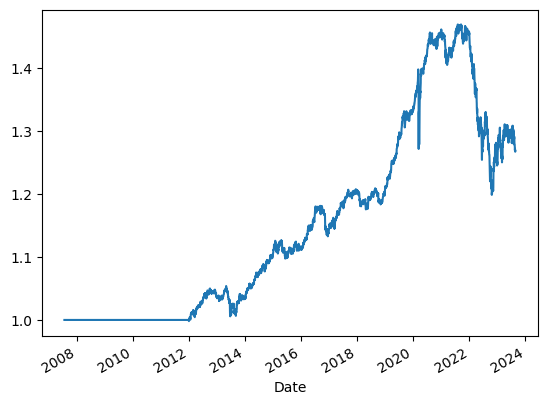

In [45]:
def calculate_dynamic_wealth_evolution(log_returns, weight_decisions):
    weighted_returns = (log_returns * weight_decisions).sum(axis=1)
    wealth_evolution = np.exp(weighted_returns.cumsum())
    return wealth_evolution

wealth_evolution = calculate_dynamic_wealth_evolution(log_returns,dynamic_weights)
wealth_evolution.plot()

In [48]:
rets = wealth_evolution[wealth_evolution.index >= start_investing].pct_change().dropna()
sharpe_ratio = sharpe(rets,RFR, TRADING_DAYS)
print(f"SR since we start investing: {sharpe_ratio:.4f}")

rets = wealth_evolution.pct_change().dropna()
sharpe_ratio = sharpe(rets,RFR, TRADING_DAYS)
print(f"SR from the beginning: {sharpe_ratio:.4f}")

SR since we start investing: 0.0369
SR from the beginning: -0.1070
